## Import Packages and Load Data

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from preprocess import * 
import xgboost
import umap
import umap.plot
import warnings
warnings.filterwarnings('ignore')

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:
# Load the training data from a CSV file located in the "data" directory
train_data = pd.read_csv(os.path.join("data", "train.csv"))

# Load the test data from a CSV file located in the "data" directory
test_data = pd.read_csv(os.path.join("data", "test.csv"))

# Fill missing values in the "description" column of the training data with empty strings
train_data["description"].fillna("", inplace=True)

# Fill missing values in the "host_is_superhost" column of the training data with "f" (assumed to mean "false")
train_data["host_is_superhost"].fillna("f", inplace=True)

# Fill missing values in the "beds" column of the training data with "1" (assumption)
train_data["beds"].fillna("1", inplace=True)

# Remove rows with missing values in any column from the training data
train_data.dropna(inplace=True)

# Separate the features (X) and the target variable (y) from the training data
X, y = train_data.drop(["price"], axis=1), train_data["price"]

# Split the training data into training and validation sets
# - 80% for training, 20% for validation
# - Use a random seed (random_state=42) for reproducibility
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

# Assign the test data to the variable X_test for further processing
X_test = test_data

# Apply a preprocessing function (preprocess) to the training, validation, and test data
X_train, X_val, X_test = preprocess(X_train), preprocess(X_val), preprocess(X_test)


In [3]:
# Check if a GPU (cuda) is available; otherwise, use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define a custom dataset class for the Airbnb data
class AirBnbDataset(Dataset): 
    
    def __init__(self, X, y): 
        
        # Initialize the dataset
        # First, train the StandardScaler to the preprocessed training set only 
        scaler = StandardScaler() 
        scaler.fit(X_train) 
        
        # Now, convert this pandas dataframe to a numpy array and scale it 
        X = X.to_numpy().astype(float)
        X = scaler.transform(X) 
        
        # Convert the features and target to PyTorch tensors
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.to_numpy().reshape(-1, 1), dtype=torch.float32)
        self.num_features = self.X.size()[1]
    
    def __len__(self): 
        # Define the length of the dataset
        return self.X.size()[0] 
    
    def __getitem__(self, i): 
        # Get an item (features and label) at index i
        return (self.X[i, :], self.y[i])

# Create datasets for training and validation
trainset = AirBnbDataset(X_train, y_train) 
valset = AirBnbDataset(X_val, y_val)

# Create data loaders for training and validation
# DataLoader helps with batch processing and shuffling the data
trainloader = DataLoader(trainset, batch_size=512, shuffle=True)
valloader = DataLoader(valset, batch_size=512, shuffle=True)


In [4]:
# Define a custom neural network class that inherits from nn.Module
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output layer with 1 neuron for regression
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Define a function to convert target values to one-hot encoded format (not currently used)
def oneHot(y):
    one_hot = torch.zeros(len(y), 6)
    for idx, class_num in enumerate(y):
        one_hot[idx, class_num] = 1 
    return one_hot

# Define a training function that performs forward and backward passes
def train(dataloader, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    model.train()
    correct = 0 
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        correct += (pred.to(torch.int32) == y.to(torch.int32)).type(torch.float).sum().item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    correct /= size
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}% \n")
            
    return loss 
            
# Define a testing function to evaluate the model's performance on the test dataset
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.to(torch.int32) == y.to(torch.int32)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.5f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss


In [5]:
# Create an instance of the NeuralNetwork class, specifying the input size
model = NeuralNetwork(trainset.num_features).to(device)

# Define the loss function (mean squared error, MSE) for regression
loss_fn = nn.MSELoss()

# Define the optimizer (Stochastic Gradient Descent) with learning rate, momentum, and weight decay
optimizer = torch.optim.SGD(
    model.parameters(),     # Which parameters to optimize
    lr=1e-3,                # Learning rate
    momentum=0.9,           # Momentum for gradient updates
    weight_decay=1e-3       # Weight decay for regularization
)

# Define a learning rate scheduler (LinearLR)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)

# Specify the number of training epochs
epochs = 112

# Lists to store training and validation losses for each epoch
train_losses, val_losses = [], []

# Training loop
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    # Train the model and append the training loss to the list
    train_losses.append(train(trainloader, model, loss_fn, optimizer, scheduler))
    
    # Evaluate the model on the validation data and append the validation loss to the list
    val_losses.append(test(valloader, model, loss_fn))
    
    # Learning rate scheduling is not used in this code snippet
    # scheduler.step() 
    
print("Done!")


Epoch 1
-------------------------------
loss: 6.810975  [  512/12346]
Train Error: 
 Accuracy: 26.0% 

Test Error: 
 Accuracy: 26.01231%, Avg loss: 4.235076 

Epoch 2
-------------------------------
loss: 4.484324  [  512/12346]
Train Error: 
 Accuracy: 24.1% 

Test Error: 
 Accuracy: 19.40395%, Avg loss: 2.624271 

Epoch 3
-------------------------------
loss: 2.775518  [  512/12346]
Train Error: 
 Accuracy: 18.3% 

Test Error: 
 Accuracy: 18.62650%, Avg loss: 2.519124 

Epoch 4
-------------------------------
loss: 2.835075  [  512/12346]
Train Error: 
 Accuracy: 18.8% 

Test Error: 
 Accuracy: 19.30677%, Avg loss: 2.439420 

Epoch 5
-------------------------------
loss: 2.378460  [  512/12346]
Train Error: 
 Accuracy: 19.4% 

Test Error: 
 Accuracy: 19.85747%, Avg loss: 2.254232 

Epoch 6
-------------------------------
loss: 2.370206  [  512/12346]
Train Error: 
 Accuracy: 20.0% 

Test Error: 
 Accuracy: 20.11662%, Avg loss: 2.199873 

Epoch 7
-------------------------------
loss: 

Text(0, 0.5, 'Loss')

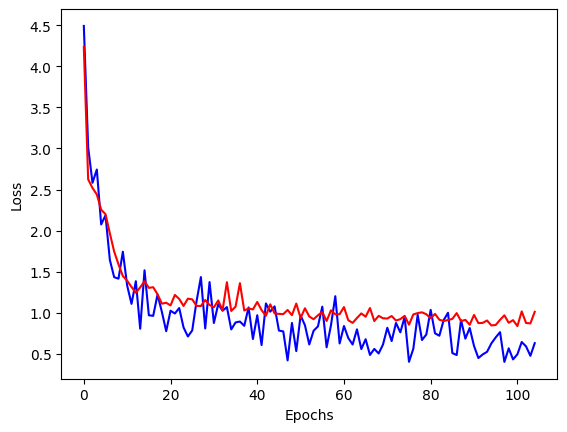

In [8]:
# Create a line plot to visualize training and validation losses over epochs
plt.plot([x.detach().cpu().numpy() for x in train_losses], c="b", label="Train Loss")  # Training loss in blue
plt.plot([x for x in val_losses], c="r", label="Validation Loss")  # Validation loss in red

# Label the x-axis and y-axis
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Add a legend to differentiate between training and validation losses
plt.legend()


In [9]:
# Import the classification_report function from scikit-learn
from sklearn.metrics import classification_report

# Initialize a StandardScaler and fit it to the training data
scaler = StandardScaler() 
scaler.fit(X_train) 

# Transform the validation data using the same scaler
X_val_input = X_val.to_numpy().astype(float)
X_val_input = scaler.transform(X_val_input) 

# Convert the scaled validation data to a PyTorch tensor and move it to the specified device (GPU or CPU)
X_val_input = torch.tensor(X_val_input, dtype=torch.float32).to(device)

# Make predictions on the validation data using the trained neural network model
x_test_pred = model(X_val_input).to(int)

# Print the classification report, which includes various classification metrics
# such as precision, recall, F1-score, and support for each class
print(classification_report(y_val, x_test_pred.detach().cpu().numpy(), digits=5))


              precision    recall  f1-score   support

         0.0    0.69471   0.80905   0.74753       796
         1.0    0.37279   0.46206   0.41265       593
         2.0    0.27731   0.39364   0.32539       503
         3.0    0.36408   0.26596   0.30738       564
         4.0    0.38767   0.23097   0.28947       381
         5.0    0.87931   0.20400   0.33117       250
         6.0    0.00000   0.00000   0.00000         0
         7.0    0.00000   0.00000   0.00000         0
         8.0    0.00000   0.00000   0.00000         0
         9.0    0.00000   0.00000   0.00000         0

    accuracy                        0.45513      3087
   macro avg    0.29759   0.23657   0.24136      3087
weighted avg    0.48151   0.45513   0.44375      3087

